In [1]:
import sys
sys.path.append("/home/ex/Documents/Hons/CBT/Skogestad-Python")
import utils
import numpy
import matplotlib.pyplot as plt

In [2]:
class PlantModel:
    def __init__(self, G, x0=None):
        self.G = G
        if x0 is None:
            self.x = numpy.zeros(G.A.shape[0])
            
        self.zs = []
        

    def step(self, u, dt):
        """
        Steps the response of the system to the input.
        Uses a Runge-Kutta delay integration routine.
        Parameters:
            u:      array_like
                    The input to the system.
            dt:     float
                    A scalar indicating the time sincde the previous call

        Returns:
            y:      array_like
                    The output from the system

        """

        dtss = [int(numpy.round(delay / dt)) for delay in self.G.delays]

        def wf():
            ws = []
            for i, dts in enumerate(dtss):
                if len(self.zs) <= dts:
                    ws.append(0)
                elif dts == 0:
                    ws.append(self.zs[-1][i])
                else:
                    ws.append(self.zs[-dts][i])

            return numpy.array(ws)

        def f(t, x):
            return self.G.A @ x + self.G.B1 @ u + self.G.B2 @ wf()

        # y
        y = self.G.C1 @ numpy.array(self.x) + self.G.D11 @ u + self.G.D12 @ wf()

        # z
        z = self.G.C2 @ numpy.array(self.x) + self.G.D21 @ u + self.G.D22 @ wf()
        self.zs.append(list(z))

        # x integration
        k1 = f(t, self.x) * dt
        k2 = f(t + 0.5 * dt, self.x + 0.5 * k1) * dt
        k3 = f(t + 0.5 * dt, self.x + 0.5 * k2) * dt
        k4 = f(t + dt, self.x + k3) * dt
        dx = (k1 + k2 + k2 + k3 + k3 + k4) / 6
        self.x = [xi + dxi for xi, dxi in zip(self.x, dx)]

        return y


In [3]:
# Slightly adapted from  H/W assignment 9
num = [[[-0.045], [-0.048]], [[-0.23], [0.55]]]
den = [[[1, -4, 5], [11, 1]], [[8.1, 1], [10, 1]]] # [[[8.1, 1], [11, 1]], [[8.1, 1], [10, 1]]]
delay = [[0.5, 0.5], [1.5, 0.5]]
G = utils.InternalDelay.from_tf_coefficients(num, den, delay)

In [4]:
pm = PlantModel(G)

ts = numpy.linspace(0 , 100, 1000)
dt = ts[1]

def uf(t):
    dU1 = [-1.5]*10 + [2]*7 + [0]*3
    dU2 = [1] + [0]*9 + [-1] + [0]*9
    tstep = numpy.arange(0, 20, 1)

    U1, U2 = numpy.cumsum(dU1), numpy.cumsum(dU2)
    if t < len(dU1):
        return [U1[numpy.where(tstep <= t)[0][-1]], U2[numpy.where(tstep <= t)[0][-1]]]
    else:
        return [U1[-1], U2[-1]]
ys_m = []

for t in ts:
    U = uf(t) 
    ys_m.append(pm.step(U, dt))
    
ys_m = numpy.array(ys_m)

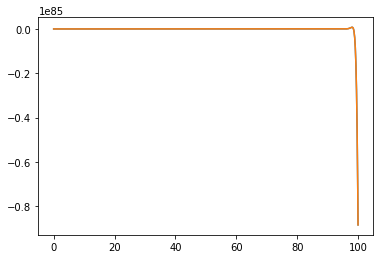

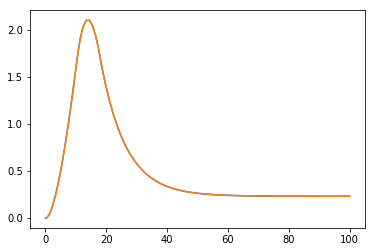

In [5]:
ys = G.simulate(uf, ts)

plt.plot(ts, ys[:, 0])
plt.plot(ts, ys_m[:, 0])
plt.show()

plt.plot(ts, ys[:, 1])
plt.plot(ts, ys_m[:, 1])
plt.show()